In this project, we'll use transfer learning to train a model to classify images.

Transfer learning consists in using a pretrained model with weights learned from another problem and adjust it to the needs of another problem.

In particular, we'll use the pretrained [ResNet-50](https://docs.pytorch.org/vision/stable/models/resnet.html) model from `torchvision.models` and adjust it to classify images from the [EuroSAT dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.EuroSAT.html#torchvision.datasets.EuroSAT).

Here are the steps we're going to follow:

1) Data preparation<br>
2) Adjusting the pretrained model<br>
3) Training the model<br>
4) Evaluating the model<br>
5) Making predictions on the test set

Without further ado, let's just jump right in.


# 1) Data Preparation

Let's start by importing the stuff we're going to need:

In [92]:
# Operating System and Filesystem
import os
import shutil
from pathlib import Path

# Data Structures and Typing
from typing import Dict, List, Tuple

# Image Processing
from PIL import Image

# Randomization and Sampling
import random

# Numerical and Scientific Computing
import numpy as np

# Machine Learning and Model Selection
from sklearn.model_selection import train_test_split

# Deep Learning and Computer Vision
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT, ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.utils
from torch.utils.data import DataLoader

# Visualization and Plotting
import matplotlib.pyplot as plt

Let's set up device-agnostic code:

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

As we're going to use a pretrained model, it's important to prepare our data in the same way as the data that was used to train the pretrained model. What it exactly means is we have to apply the same transformations to our data as the ones applied to the original data.

Let's go to the [ResNet-50](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50) documentation and find out what transformations were used. Here's what we can see there:

*The inference transforms are available at ResNet50_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].*

Let's compose a series of transformations to apply to our dataset so that it matches the original one. They'll include resizing the images to 224x224, converting them into tensors and normalizing them:

In [69]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Let's download the data and apply the transformations while we do it:

In [70]:
data = EuroSAT(
    root="data",
    download=True,
    transform=data_transforms
)

100%|██████████| 94.3M/94.3M [00:00<00:00, 352MB/s]


Let's transform the dataset into a a standard image classification format after downloading it. This format is typically used for image classification datasets. We create separate folders for training and test data and inside each of them we create a separate folder for each class with the images belonging to that class. The structure looks like so:

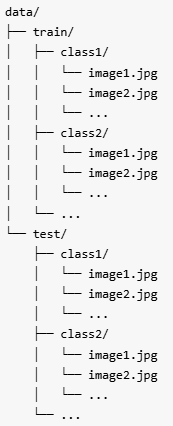

Here's how we can do it:

In [72]:
# paths for train and test directories
train_dir = 'data/train'
test_dir = 'data/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# subdirectories for the classes
for class_name in data.classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Split the data and move the images.
# image indices for train and test splits
train_indices, test_indices = train_test_split(np.arange(len(data)), test_size=0.2, random_state=42)

# Move the images to respective folders based on the split
for i in train_indices:
    image, label = data[i]
    class_name = data.classes[label]
    torchvision.utils.save_image(image, os.path.join(train_dir, class_name, f'image_{i}.jpg'))  # Save image as JPG

for i in test_indices:
    image, label = data[i]
    class_name = data.classes[label]
    torchvision.utils.save_image(image, os.path.join(test_dir, class_name, f'image_{i}.jpg'))  # Save image as JPG

Let's remove the `eurosat` folder from the `data` folder:

In [73]:
# Define the path to the eurosat folder
eurosat_folder_path = os.path.join("data", "eurosat")

# Remove the eurosat folder and its contents
try:
    shutil.rmtree(eurosat_folder_path)
    print(f"Successfully removed the folder: {eurosat_folder_path}")
except OSError as e:
    print(f"Error: {e.filename} - {e.strerror}")

Successfully removed the folder: data/eurosat


The image will be classified into one of ten classes. Here are the classes:

In [74]:
classes = data.classes
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Next, let's create the dataset and dataloaders. These are PyTorch concepts used for efficiently managing and feeding data to the model.

In [75]:
train_dataset = ImageFolder(train_dir, transform=data_transforms)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

test_dataset = ImageFolder(test_dir, transform=data_transforms)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

`ImageFolder` is a class from `torchvision.datasets` that is used to create a dataset from a folder containing images organized in subfolders representing different classes. This aligns with the standard image classification dataset structure created in the data preparation steps.


`train_dir` and `test_dir` are variables holding the paths to the training and testing image folders respectively.


`transform=data_transforms` specifies the image transformations defined earlier using `transforms.Compose`. These transformations like resizing and normalization will be applied to each image loaded from these folders.
This essentially means the `train_dataset` and `test_dataset` objects will contain the image data along with their corresponding labels (class information) ready to be used for training and testing.

`DataLoader` is a class from `torch.utils.data` that is used to create an iterable over the dataset enabling efficient batching and loading of data during training and evaluation.

`train_dataset` and `test_dataset` are dataset objects created using `ImageFolder` as discussed above.

`batch_size=32` specifies the number of images to be included in each batch fed to the model at a time.

`shuffle=True` in `train_dataloader` is used to shuffle the data in each epoch during training, which is a common practice to aid in generalization. For testing (`test_dataloader`), `shuffle=False` is set as the order of data during evaluation doesn't usually matter.

`num_workers=os.cpu_count()` determines the number of subprocesses to use for data loading. Utilizing multiple CPU cores can speed up the data loading process.

`pin_memory=True` is used to copy data into pinned memory before returning it, leading to faster data transfer to the GPU.

Next, let's get the pretrained model to work for us.

# 2) Adjusting the Pretrained Model

When we use a pretrained model, we have access to its parameters that were learned during its training. In case of ResNet-50 we can do it like so:

`weights = ResNet50_Weights.IMAGENET1K_V2`

or

`weights = ResNet50_Weights.DEFAULT`

The `DEFAULT` option, just like with any other model, means the best available weights, so the weights from the best performance in ImageNet. The ImageNet is the dataset the model was trained on.

So, let's use the latter one:

In [76]:
weights = ResNet50_Weights.DEFAULT

Now, we can can set up the model with the pretrained weights and put it on the target device:

In [77]:
model = resnet50(weights=weights).to(device)

Let's have a look at the model. It's pretty complex:

In [78]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Let's analyze the model before we move on. Here's its simplified representation:

`Input -> Input Stem -> Residual Blocks (layer1-layer4) -> Average Pooling -> Fully Connected Layer (Classifier) -> Output`

Let's break down the main parts of the ResNet50 model.

ResNet50, a 50-layer deep residual network, has the following primary components:

**1. Input Stem:**

This part comprises an initial convolutional layer (`conv1`), a batch normalization layer (`bn1`), a ReLU activation function (`relu`) and a Max Pooling layer (`maxpool`).


It processes the input image, preparing it for further processing by the residual blocks.


**2. Residual Blocks:**

These are the core building blocks of ResNet50 and contribute to its depth and ability to learn complex features. Each block consists of multiple convolutional layers, batch normalization, and ReLU activations, with skip connections (residual pathways) that allow information to flow directly through the block without being lost.


ResNet50 has four stages of residual blocks, each with a varying number of blocks:

layer1: 3 residual blocks<br>
layer2: 4 residual blocks<br>
layer3: 6 residual blocks<br>
layer4: 3 residual blocks<br>

**3. Average Pooling:**

After the residual blocks, an average pooling layer (`avgpool`) is applied to downsample the feature maps and create a global representation of the image.

**4. Fully Connected Layer (Classifier):**

This is the final layer of the model, denoted as `fc`. It takes the output from the average pooling layer and performs the classification task by mapping the features to the desired number of classes.

We don't want to change the weights that have been learned during the training of the pretrained model, we only only want to change the output layer, the classifier. This is why we have to freeze all the layers except the classifier.

Freezing layers prevents their weights from being updated during training, preserving the pre-trained knowledge. By only unfreezing the classifier, you allow the model to adapt to your specific task while leveraging the feature extraction capabilities of the pre-trained layers.

We can freeze the layers by setting their `requires_grad` attribute to `False`. The easiest way to do it is to freeze all the layers and then unfreeze the classifier layer:

In [79]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

The layers, except the classifier ones, shouldn't be trainable anymore. Let's use the `summary` function from the `torchinfo` module to check it out:

In [93]:
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

summary(
    model=model,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

Let's have a closer look at the classifier again:

`(fc): Linear(in_features=2048, out_features=1000, bias=True)`

The pretrained model has 1000 output features because there are 1000 classes in ImageNet, but we only have 10 classes in our model:

In [81]:
output_shape = len(classes)
output_shape

10

So, let's change the number of output features to 10 in the classifier, and also, let's put in on the device:

In [82]:
model.fc = nn.Linear(in_features=2048, out_features=output_shape, bias=True).to(device)

With this in place, we'ready to train our model.

# 3) Training the Model

First of all, we need a loss function and an optimizer. Let's use cross entropy and Adam respectively:

In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

This loss function is commonly used for multi-class classification problems (like in this case where we're classifying images into 10 different categories).
It calculates a logarithmic loss between the predicted probabilities and the true labels, guiding the model to learn better by minimizing this loss during training.

The Adam optimizer is a popular optimization algorithm in deep learning. It combines the benefits of two other optimizers (AdaGrad and RMSProp) and is known for its efficiency and relatively low memory requirements.

We'll first define a couple functions to simplify the process of model learning a bit. The first two functions, `train_step` and `test_step`, are used for a single training or testing step. They're used inside the `train` function, which is used to perform the entire training process.

So, here's the `train_step` function:

In [84]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # put model in train mode
    model.train()

    # set up train loss and train accuracy
    train_loss, train_acc = 0, 0

    # loop through the Dataloader batches
    for batch, (X, y) in enumerate(dataloader):

        # put data on target device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)

        # loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # zero grad
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # optimizer step
        optimizer.step()

        # accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Here's the `test_step` function:

In [85]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # put model in eval mode
    model.eval()

    # set up test loss and test accuracy
    test_loss, test_acc = 0, 0

    # use the inference context manager
    with torch.inference_mode():

        # loop through the Dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # put data on target device
            X, y = X.to(device), y.to(device)

            # forward pass
            test_pred_logits = model(X)

            # loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Let's cobine the two functions in the `train` function that will be used to trained the model for multiple epochs:

In [86]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # create an empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # loop through the training and test steps for the specified number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # print some information
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        # update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # return the results dictionary
    return results

With the functions defined, we can now train the model:

In [87]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

Epoch: 1 | train_loss: 1.0896 | train_acc: 0.6188 | test_loss: 0.8368 | test_acc: 0.6934
Epoch: 2 | train_loss: 0.8484 | train_acc: 0.6828 | test_loss: 0.7629 | test_acc: 0.7178
Epoch: 3 | train_loss: 0.7941 | train_acc: 0.7080 | test_loss: 0.7365 | test_acc: 0.7247
Epoch: 4 | train_loss: 0.7646 | train_acc: 0.7119 | test_loss: 0.7276 | test_acc: 0.7265
Epoch: 5 | train_loss: 0.7351 | train_acc: 0.7206 | test_loss: 0.7181 | test_acc: 0.7291


The test accuracy is not ideal, but pretty OK. Let's evaluate the model.

# 4) Evaluating the Model

In order to evaluate the model, we'll plot the loss curves. They'll tell us whether the model is overfitting, underfitting or doing just fine:

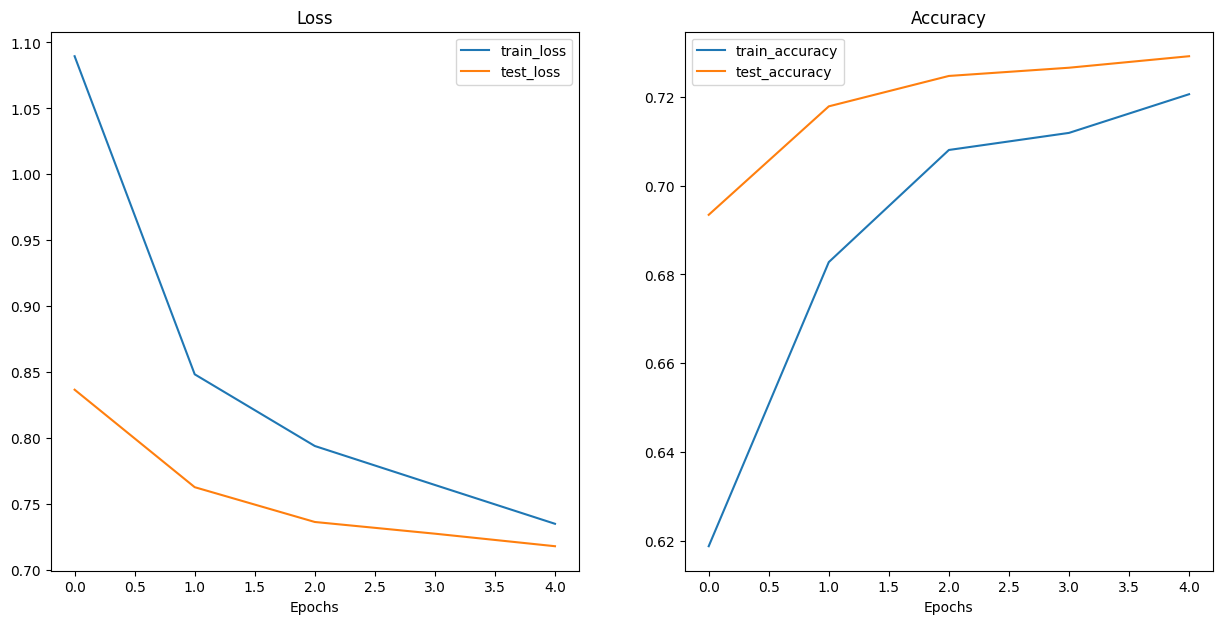

In [89]:
    # loss values
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # accuracy values
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # number of epochs
    epochs = range(len(results['train_loss']))

    # the plots
    plt.figure(figsize=(15, 7))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Here's how we can interpret the curves:

**Ideal scenario:**

Loss Plot: Both training and testing loss curves should decrease over time and eventually stabilize.

Accuracy Plot: Both training and testing accuracy curves should increase over time and eventually stabilize at a high value.

**Possible Outcomes:**

***1. Overfitting:***

Loss Plot: Training loss decreases significantly, but testing loss starts to increase or plateau.

Accuracy Plot: Training accuracy continues to increase, but testing accuracy starts to decrease or plateau.

Interpretation: The model is memorizing the training data and is not generalizing well to new, unseen data.

***2. Underfitting:***

Loss Plot: Both training and testing losses remain high and do not decrease much.

Accuracy Plot: Both training and testing accuracies remain low.

Interpretation: The model is too simple to capture the underlying patterns in the data.

***3. Good Fit/Generalization:***

Loss Plot: Both training and testing losses decrease and stabilize.

Accuracy Plot: Both training and testing accuracies increase and stabilize at a high value. There's only a small gap between training and testing accuracy.

Interpretation: The model is learning effectively from the training data and generalizing well to unseen data.<br><br>


**In our case the following is true:**

Loss Curves: They're both moving downwards and the gap between them isn't very big.

Accuracy Curves: They're both moving upwards and the gap between them isn't very big either.

Looks like our model is doing really well. Let's use it to make some predictions then.

# 5) Making Predictions on the Test Set

Finally, let's use the model to make a prediction on the test set. First, we'll define a function to predict and plot a single image and then we'll use it to predict and plot several images. Here's the function:

In [90]:
def predict_and_plot_image(
    model: torch.nn.Module,
    classes: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device=device):

    # open image
    img = Image.open(image_path)

    # compose transformations
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # put model on target device
    model.to(device)

    # eval and inference mode
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # make prediction
      target_image_pred = model(transformed_image.to(device))

    # logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # plot image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Prediction: {classes[target_image_pred_label]} | Probability: {target_image_pred_probs.max():.2f}")
    plt.axis(False);

Now let's predict and plot a couple images from the test set:

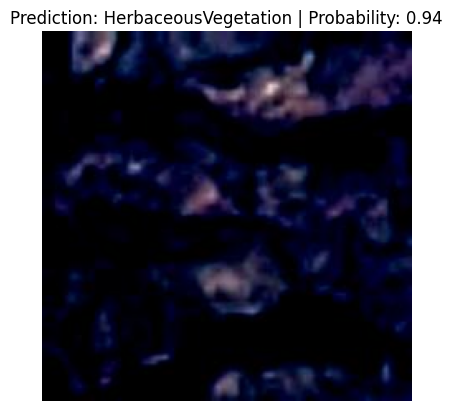

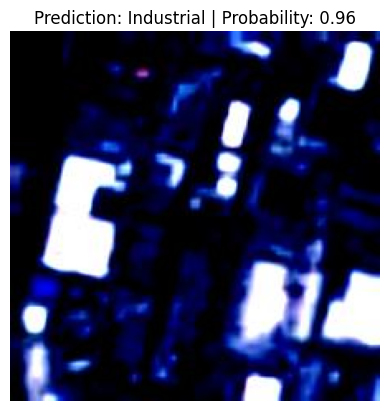

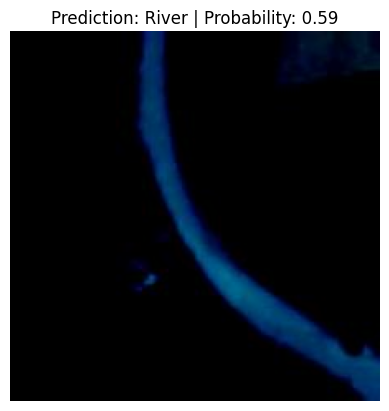

In [91]:
# a sample from test set
sample_size = 3
image_paths = list(Path(test_dir).glob("*/*.jpg"))
image_sample = random.sample(population=image_paths, k=sample_size)

# predict and plot
for image_path in image_sample:
    predict_and_plot_image(
        model=model,
        classes=classes,
        image_path=image_path,
        image_size=(224, 224),
        transform=weights.transforms()
    )

These predictions are pretty high, so the model isn't that bad after all.

# Conclusion

In this project, we successfully employed transfer learning using a pre-trained ResNet-50 model to classify images from the EuroSAT dataset. By leveraging the pre-trained weights and fine-tuning the classifier, the model was able to achieve reasonably good performance.

The training process involved preparing the data, adjusting the pre-trained model, training the model, evaluating its performance through loss and accuracy curves, and finally making predictions on the test set.

The training and test accuracy curves were moving in a desirable direction (increasing accuracy, decreasing loss).

Despite some room for further improvement, the prediction results were high. It demonstrates the effectiveness of transfer learning for image classification. This project provides a foundation for further exploration and optimization, such as hyperparameter tuning, data augmentation, or exploring different architectures, to achieve even higher accuracy and better generalization.

Overall, the project showcases the potential of transfer learning for efficiently building image classification models, achieving satisfactory results with reduced training time and effort.